In [10]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Define Generator
class Generator(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, output_dim),
            nn.Tanh()  # To get values in range (-1, 1)
        )

    def forward(self, x):
        return self.model(x)

# Define Discriminator
class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# Hyperparameters
latent_dim = 100
image_size = 28 * 28
batch_size = 64
epochs = 100
lr = 0.0002

# # Model initialization
# generator = Generator(latent_dim, image_size)
# discriminator = Discriminator(image_size)

# Optimizers
optim_g = optim.Adam(generator.parameters(), lr=lr)
optim_d = optim.Adam(discriminator.parameters(), lr=lr)

# Loss function
criterion = nn.BCELoss()

# Dataset and DataLoader
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

import torch

# Check if CUDA is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Assuming generator and discriminator are already defined
generator = Generator(latent_dim, image_size).to(device)  # Move generator to GPU
discriminator = Discriminator(image_size).to(device)  # Move discriminator to GPU

# Criterion and optimizers
criterion = torch.nn.BCELoss()
optim_g = torch.optim.Adam(generator.parameters(), lr=0.0002)
optim_d = torch.optim.Adam(discriminator.parameters(), lr=0.0002)

# Training loop
for epoch in range(epochs):
    for i, (images, _) in enumerate(dataloader):
        real_batch_size = images.size(0)

        # Move real images and labels to the GPU
        real_images = images.view(real_batch_size, -1).to(device)  # Move images to GPU
        real_labels = torch.ones(real_batch_size, 1).to(device)  # Move labels to GPU
        fake_labels = torch.zeros(real_batch_size, 1).to(device)  # Move labels to GPU

        # Train discriminator
        noise = torch.randn(real_batch_size, latent_dim).to(device)  # Move noise to GPU
        fake_images = generator(noise)

        # Ensure the inputs to the loss function are on the same device
        d_loss_real = criterion(discriminator(real_images), real_labels)
        d_loss_fake = criterion(discriminator(fake_images.detach()), fake_labels)
        d_loss = d_loss_real + d_loss_fake

        # Backprop and optimization
        optim_d.zero_grad()
        d_loss.backward()
        optim_d.step()

        # Train generator
        noise = torch.randn(real_batch_size, latent_dim).to(device)  # Move noise to GPU
        fake_images = generator(noise)
        g_loss = criterion(discriminator(fake_images), real_labels)  # Ensure labels are on the same device

        optim_g.zero_grad()
        g_loss.backward()
        optim_g.step()

    print(f'Epoch [{epoch+1}/{epochs}], d_loss: {d_loss.item()}, g_loss: {g_loss.item()}')


Epoch [1/100], d_loss: 0.011646351777017117, g_loss: 7.831570625305176
Epoch [2/100], d_loss: 2.3002688884735107, g_loss: 12.250798225402832
Epoch [3/100], d_loss: 2.3111929893493652, g_loss: 0.9237568974494934
Epoch [4/100], d_loss: 0.4593685567378998, g_loss: 2.5067381858825684
Epoch [5/100], d_loss: 0.3217366337776184, g_loss: 2.6575064659118652
Epoch [6/100], d_loss: 0.32831570506095886, g_loss: 2.8030290603637695
Epoch [7/100], d_loss: 0.24324549734592438, g_loss: 2.619372844696045
Epoch [8/100], d_loss: 0.4711700677871704, g_loss: 3.397582530975342
Epoch [9/100], d_loss: 0.2948698401451111, g_loss: 6.932218551635742
Epoch [10/100], d_loss: 0.18823561072349548, g_loss: 6.902254104614258
Epoch [11/100], d_loss: 0.2817057967185974, g_loss: 3.9164528846740723
Epoch [12/100], d_loss: 0.19850178062915802, g_loss: 5.731531620025635
Epoch [13/100], d_loss: 0.23685894906520844, g_loss: 6.075436592102051
Epoch [14/100], d_loss: 0.42450153827667236, g_loss: 5.089434623718262
Epoch [15/100],

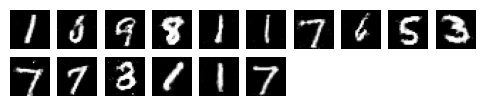

In [20]:
# Generating and displaying some images
import torch
import matplotlib.pyplot as plt

# Assuming `latent_dim` and `generator` are already defined
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the generator model to the same device
generator.to(device)

# Generating and displaying some images
# Move noise to the same device as the generator
noise = torch.randn(16, latent_dim).to(device)
generated_images = generator(noise).view(-1, 28, 28).detach().cpu()  # Move generated images to CPU for plotting

# Plotting the generated images
plt.figure(figsize=(6, 6))
for i in range(16):
    plt.subplot(10, 10, i+1)
    plt.imshow(generated_images[i], cmap='gray')
    plt.axis('off')
plt.show()


In [22]:
!pip install gradio


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.1/18.1 MB 78.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.7/318.7 kB 20.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 96.8 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.3/126.3 kB 9.3 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.26.18
    Uninstalling urllib3-1.26.18:
      Successfully uninstalled urllib3-1.26.18
  Attempting uninstall: tomlkit
    Found existing installation: tomlkit 0.13.2
    Uninstalling tomlkit-0.13.2:
      Successfully uninstalled tomlkit-0.13.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
distributed 2024.7.1 requires dask==2024.7.1, but you have dask 2024.9.0 which is incompatible.
kfp 2.5.0 requires google-cloud-storage<3,>=2.2.1, but you have goog

In [23]:
from flask import Flask
import torch
import torch.nn as nn
import gradio as gr

app = Flask(__name__)

noise = torch.randn(16, latent_dim).to(device)
generated_images = generator(noise).view(-1, 28, 28).detach().cpu()  # Move generated images to CPU for plotting


# Load your trained model (replace with the correct file path if loading)
generator = Generator(latent_dim=100, output_dim=28*28)
generator.load_state_dict(torch.load('generator.pth'))
generator.eval()

# Gradio interface for generating images
def generate_images(noise_vector):
    noise = torch.tensor(noise_vector).view(1, -1).float()
    with torch.no_grad():
        fake_image = generator(noise).view(28, 28)
    return fake_image.numpy()

# Create the Gradio Interface
iface = gr.Interface(
    fn=generate_images,
    inputs=gr.inputs.Textbox(label="Enter Noise Vector (comma-separated 100 values)"),
    outputs="image",
    description="GAN-based Image Generator"
)

@app.route('/')
def home():
    iface.launch(share=True)
    return "Visit the Gradio link to generate images."

if __name__ == "__main__":
    app.run()


TypeError: Generator.__init__() got an unexpected keyword argument 'latent_dim'